# LiDAR to tree crowns

The computational workflows from the [train-crown](https://github.com/martibosch/swiss-urban-trees/blob/main/notebooks/train-crown.ipynb) and [multi-species-model](https://github.com/martibosch/swiss-urban-trees/blob/main/notebooks/multi-species-model.ipynb) notebooks illustrate how to detect individual tree crowns and infer tree species from aerial imagery. Nonetheless, as suggested in the notebooks, scaling the workflows at the Swiss country scale would likely require a substantial amount of high quality ground truth annotations, which often means a significant amount of manual work.

Luckily, swisstopo offers [swissSURFACE3D](https://www.swisstopo.admin.ch/en/height-model-swisssurface3d), a high-resolution point cloud dataset (min 5 pts/m^2, mean between 15-20 pts/m^2) [collected by airborne Light Detection and Ranging (LiDAR) throughout Switzerland](https://www.swisstopo.admin.ch/en/lidar-data-swisstopo). Moreover, the dataset [is openly available](https://www.swisstopo.admin.ch/en/terms-of-use-free-geodata-and-geoservices) and [programatically accessible through a STAC API](https://www.geo.admin.ch/en/rest-interface-stac-api).

Developments in LiDAR data processing show that it allows the identification not only tree crowns but also key morphological attributes such as tree height, diameter at breast height (DBH), leaf area index (LAI), aboveground biomass (AGB) and more [1-4] (here we are only citing some reviews, there is a myriad of case studies to cite) - which in turn can be used to infer tree species.

However, LiDAR data is not as widely available as aerial imagery, and the processing of LiDAR data is more computationally intensive. While a Swiss tree inventory obtained from LiDAR data would most likely be more precise than a counterpart obtained from aerial imagery, the latter has more potential to be exploited outside Switzerland, e.g., in many countries which do not have a comprehensive LiDAR dataset but do have high-resolution aerial imagery. *Therefore, the purpose of this notebook is to explore how the LiDAR products of swisstopo can be used to automatically detect individual tree crowns (and potentially species) that can later be used as ground truth annotations to train a model to detect tree crowns from aerial imagery - hence reducing the amount of manual work involved.*

There exists a wide range of available open source tools implementing algorithms to process LiDAR data, which can be divided into heuristic and machine learning-based methods [5]. Most heuristic methods to detect individual tree crowns consist of a two-step pipeline [6]. First, tree tops are detected from a canopy height model (CHM) derived from the LiDAR data. Then, region-growing algorithms to segment the tree crowns are applied from the detected tree tops. The main shortcoming of this approach is the parametrization of the algorithms, which require prior knowledge on specific tree characteristics and can be challenging to tune for different datasets. To overcome these issues, recent years have seen a surge in the application of machine learning methods, which can be broadly divided into classic machine learning algorithms over engineered features and deep learning.

But let us not get ahead of ourselves and first explore what can be accomplished with simple heuristic methods. *Note that this notebook is a work in progress and is likely to be updated (very) soon, potentially with machine learning/deep learning methods.*

In [ ]:
import logging as lg
import tempfile
import zipfile
from os import path

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pooch
import rasterio as rio
from rasterio import mask, windows
from shapely import geometry

from deepforest import utilities
from swiss_urban_trees import canopy_utils, plot, stac_utils

# disable logs unless they are errors, see https://github.com/fatiando/pooch/issues/302
pooch.get_logger().setLevel(lg.CRITICAL)

# see https://www.swisstopo.admin.ch/en/height-model-swisssurface3d
LIDAR_TREE_VALUES = [3]


# we define here a very ad-hoc function to get a CHM from the swisstopo STAC API
def get_chm_from_stac(
    lidar_filepath, dtm_filepath, dst_filepath, lidar_values, **gdal_kwargs
):
    """Get CHM from LiDAR (zip) and DTM files and dump it to a file."""
    # dtm_filepath = row[swissalti_id]
    with tempfile.TemporaryDirectory() as tmp_dir:
        zip_filepath = pooch.retrieve(
            lidar_filepath,
            known_hash=None,
            # path=tmp_dir,
        )
        with zipfile.ZipFile(zip_filepath) as z:
            # TODO: use pooch processor?
            # we know that there is only one file in the zip, i.e., the .las file
            lidar_filepath = z.extract(z.namelist()[0], tmp_dir)
            return canopy_utils.get_chm(
                lidar_filepath,
                dst_filepath,
                dtm_filepath=dtm_filepath,
                lidar_values=lidar_values,
                gdal_kwargs=gdal_kwargs,
            )

/home/martibosch/mambaforge/envs/swiss-urban-trees/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pj_obj_create: Open of /home/martibosch/mambaforge/envs/swiss-urban-trees/share/proj failed
pj_obj_create: Open of /home/martibosch/mambaforge/envs/swiss-urban-trees/share/proj failed
pj_obj_create: Open of /home/martibosch/mambaforge/envs/swiss-urban-trees/share/proj failed
pj_obj_create: Open of /home/martibosch/mambaforge/envs/swiss-urban-trees/share/proj failed
pj_obj_create: Open of /home/martibosch/mambaforge/envs/swiss-urban-trees/share/proj failed
pj_obj_create: Open of /home/martibosch/mambaforge/envs/swiss-urban-trees/share/proj failed
pj_obj_create: Open of /home/martibosch/mambaforge/envs/swiss-urban-trees/share/proj failed
pj_obj_create: Open of /home/martibosch/mambaforge/envs/swiss-urban-tre

In [ ]:
annot_df_filepath = "../data/raw/sitg-orthophoto-2019-tiles/annot.csv"
tile_dir = "../data/raw/sitg-orthophoto-2019-tiles"

# swisstopo stac args
swisssurface_id = stac_utils.SWISSSURFACE3D_COLLECTION_ID
swissalti_id = stac_utils.SWISSALTI3D_COLLECTION_ID
collection_client_crs = stac_utils.CLIENT_CRS
swisssurface_datetime = "2019/2019"

# rasterize args
lidar_values = LIDAR_TREE_VALUES
# we could use higher resolution to rasterize the LiDAR, but the swissalti3d resolution
# is 0.5 m, see https://www.swisstopo.admin.ch/en/height-model-swissalti3d
dst_res = 0.5
# ACHTUNG: use a dtype that can hold the maximum number of points in a pixel, then apply
# a mask (e.g., count thresohld) and write as uint8
gdal_kwargs = {
    "resolution": dst_res,
    "output_type": "idw",
    "radius": 5,
    # "data_type": "uint32",
    # "nodata": notree_val,
    "default_srs": stac_utils.SWISSSURFACE3D_CRS,
}

# viz args
figwidth = plt.rcParams["figure.figsize"][0]
figheight = plt.rcParams["figure.figsize"][1]

## Getting the CHM from the LiDAR data

We will start by getting a CHM raster for the extent of the annotated images. We can easily extract the latter using the TiFF metadata:

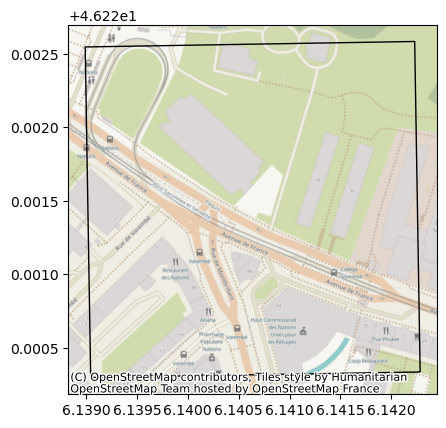

In [ ]:
# replace image paths extension from jpeg to tif (because the
# actual tiles are tif files but they have to be converted to jpeg for Label Studio)
annot_gdf = utilities.read_file(
    pd.read_csv(annot_df_filepath).assign(**{"label": "Tree"})
)
annot_gdf["image_path"] = annot_gdf["image_path"].str.replace("jpeg", "tif")

# get full path to the first (and only) annotated image
annot_img_filepath = path.join(tile_dir, annot_gdf["image_path"].iloc[0])
with rio.open(annot_img_filepath) as src:
    swisstopo_extent_gser = gpd.GeoSeries(
        geometry.box(*src.bounds), crs=src.crs
    ).to_crs(collection_client_crs)

# plot the extent with a basemap to get a grasp of it
ax = swisstopo_extent_gser.plot(facecolor="none")
cx.add_basemap(ax, crs=collection_client_crs)

In order to obtain the CHM from the raw classified point cloud data, i.e., the swissSURFACE3D dataset, we could build a pipeline using a tool such as [pdal](https://pdal.io) (e.g., see an example [here](https://www.simonplanzer.com/articles/lidar-chm) or [here](https://www.simonplanzer.com/articles/lidar-chm/)). However, since swisstopo already provides a digital terrain model (DTM) derived from the very same LiDAR data, we can skips some steps and obtain the CHM by filtering the vegetation points from the point cloud and then subtracting the DTM.

Therefore, let us now use the swisstopo STAC API to get the LiDAR data and the DTM data for this area:

In [ ]:
client = stac_utils.SwissTopoClient()

swisssurface_gdf = client.gdf_from_collection(
    swisssurface_id,
    extent_geom=swisstopo_extent_gser.iloc[0],
    datetime=swisssurface_datetime,
    extension=".zip",
)
swissalti_gdf = client.gdf_from_collection(
    swissalti_id,
    extent_geom=swisstopo_extent_gser.iloc[0],
    datetime=swisssurface_datetime,
)
# filter out rasters at 2m resolution, keep only 50 cm rasters
swissalti_gdf = swissalti_gdf[swissalti_gdf[swissalti_id].str.contains("_0.5_")]

In [ ]:
swisssurface_gdf

,ch.swisstopo.swisssurface3d,geometry
0,https://data.geo.admin.ch/ch.swisstopo.swisssu...,"POLYGON ((6.14274 46.21485, 6.14274 46.224, 6...."


In [ ]:
swissalti_gdf

,ch.swisstopo.swissalti3d,geometry
0,https://data.geo.admin.ch/ch.swisstopo.swissal...,"POLYGON ((6.14274 46.21485, 6.14274 46.224, 6...."


As we can see, the whole extent of the annotated image is contained in a single tile of the swissSURFACE3D and swissALTI3D datasets (both datasets use the same tiling). We can thus proceed to get the CHM for this area:

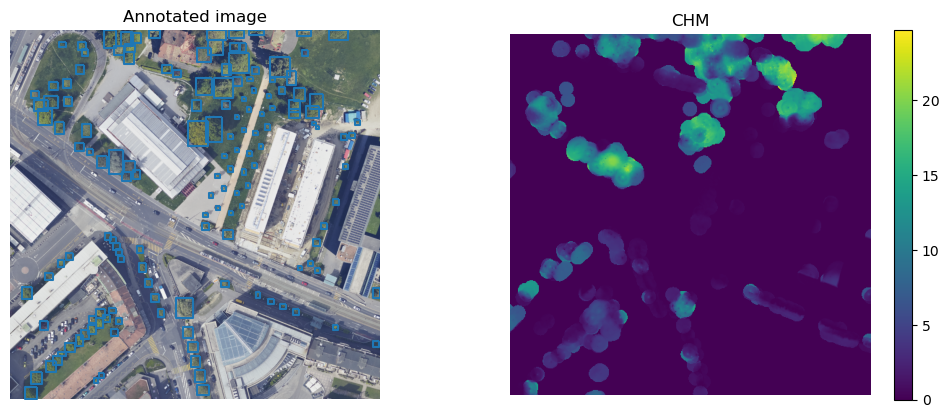

In [ ]:
with tempfile.TemporaryDirectory() as tmp_dir:
    # compute the CHM and dump it to a temporary file
    chm_filepath = get_chm_from_stac(
        # we know that both collections have the same tiling so we just get the first
        # item from each
        swisssurface_gdf.iloc[0][swisssurface_id],
        swissalti_gdf.iloc[0][swissalti_id],
        path.join(tmp_dir, "chm.tif"),
        lidar_values,
        **gdal_kwargs,
    )

    # read CHM into an array
    with rio.open(chm_filepath) as src:
        # chm_arr = src.read(1)
        # mask to our extent only, ommit the transform
        chm_arr, _ = mask.mask(src, swisstopo_extent_gser.to_crs(src.crs), crop=True)
        # get rid of outermost numpy axis i.e., the raster channel, since there is only
        # one channel in the CHM
        chm_arr = chm_arr[0]
        # crop exactly to data window
        w = windows.get_data_window(chm_arr, src.nodata)
        chm_arr = chm_arr[
            w.row_off : w.row_off + w.height, w.col_off : w.col_off + w.width
        ]

num_cols = 2
fig, axes = plt.subplots(1, num_cols, figsize=(figwidth * num_cols, figheight))
with rio.open(annot_img_filepath) as src:
    plot.plot_img_and_gdf(src, annot_gdf, ax=axes[0])
axes[0].set_title("Annotated image")
im = axes[1].imshow(chm_arr)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("CHM")

for ax in axes:
    ax.axis("off")

#### TODO: work in progress below

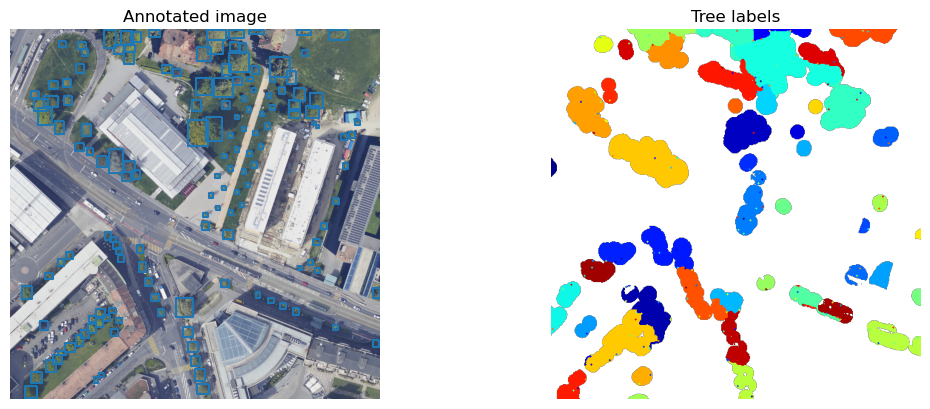

In [ ]:
import numpy as np  # noqa: E402
from scipy import ndimage as ndi  # noqa: E402
from skimage.feature import peak_local_max  # noqa: E402
from skimage.filters import gaussian  # noqa: E402
from skimage.segmentation import watershed  # noqa: E402

blur_sigma = 1
footprint_side = 10

# blur = cv.GaussianBlur(img, sigmaX=sigma, borderType=cv.BORDER_CONSTANT)
chm_blur = np.where(
    chm_arr != 0,
    gaussian(chm_arr, sigma=blur_sigma, mode="constant", cval=0, truncate=2),
    0,
)
local_maxi = peak_local_max(
    chm_blur, footprint=np.ones((footprint_side, footprint_side))
)
_arr = np.zeros_like(chm_arr)
_arr[local_maxi[:, 0], local_maxi[:, 1]] = 1
markers, num_trees = ndi.label(_arr)
chm_mask = (chm_arr != 0).astype(int)
labels = watershed(chm_blur, markers, mask=chm_mask)

# get a random color map for the plot
vals = np.linspace(0, 1, num_trees)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))

# plot the data
num_cols = 2
fig, axes = plt.subplots(1, num_cols, figsize=(figwidth * num_cols, figheight))
with rio.open(annot_img_filepath) as src:
    plot.plot_img_and_gdf(src, annot_gdf, ax=axes[0])
axes[0].set_title("Annotated image")
im = axes[1].imshow(np.where(labels != 0, labels, np.nan), cmap=cmap)
axes[1].set_title("Tree labels")

for ax in axes:
    ax.axis("off")

We are clearly failing to segment individual crowns but instead segmenting groups of canopy-overlapping trees. To improve the results, we can either (i) optimize the two parameters (`blur_sigma` and `footprint_side`) with respect to, e.g., precision, recall or F1, (ii) try another heuristic approach, e.g., pycrown or (iii) go directly to machine learning/deep learning approaches. **Expect this notebook to be updated soon.**

## References

1. Neyns, R., & Canters, F. (2022). Mapping of urban vegetation with high-resolution remote sensing: A review. Remote sensing, 14(4), 1031.
2. Yang, M., Zhou, X., Liu, Z., Li, P., Tang, J., Xie, B., & Peng, C. (2022). A review of general methods for quantifying and estimating urban trees and biomass. Forests, 13(4), 616.
3. Ocón, J. P., Stavros, E. N., Steinberg, S. J., Robertson, J., & Gillespie, T. W. (2024). Remote sensing approaches to identify trees to species-level in the urban forest: A review. Progress in Physical Geography: Earth and Environment, 48(3), 438-453.
4. Xu, D., Wang, H., Xu, W., Luan, Z., & Xu, X. (2021). LiDAR applications to estimate forest biomass at individual tree scale: Opportunities, challenges and future perspectives. Forests, 12(5), 550.
5. Murtiyoso, A., Cabo, C., Singh, A., Obaya, D. P., Cherlet, W., Stoddart, J., ... & Mokroš, M. (2024). A review of software solutions to process ground-based point clouds in forest applications. Current Forestry Reports, 10(6), 401-419.
6. Straker, A., Puliti, S., Breidenbach, J., Kleinn, C., Pearse, G., Astrup, R., & Magdon, P. (2023). Instance segmentation of individual tree crowns with YOLOv5: A comparison of approaches using the ForInstance benchmark LiDAR dataset. ISPRS Open Journal of Photogrammetry and Remote Sensing, 9, 100045.